# Student Notebook - Lecture 10

Clustering algorithms are important techniques for structural discovery in the data. In these lecture, we will solve two tasks. In a first task, you will observe and discuss performance of K-Means clustering on synthetic data. In the second task, you will yourself cluster students of a flipped classroom using spectral clustering.

In [1]:
#Important imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial import distance
from scipy.sparse.csgraph import laplacian
from scipy import linalg

from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, rand_score
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import spectral_embedding

# Data directory
DATA_DIR = "./../../data"

## K-Means Clustering - Examples

K-Means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells. K-means clustering minimizes within-cluster variances (squared Euclidean distances). In a first step, we look at K-Means clustering in detail. We first generate a synthetic example data set and write a function able to extract the intermediate cluster assignments from the K-Means algorithm. 

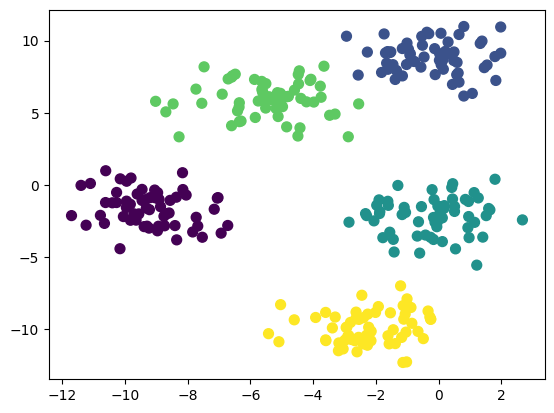

In [2]:
n_samples = 300
X, y= make_blobs(n_samples=n_samples, centers=5,
                cluster_std=1.2, random_state=2010)
plt.scatter(X[:, 0], X[:, 1], s=50, c=y)

In [3]:
def getKMeansSteps(X, k, centroids):

    y_pred = []
    intermediate_centers = []
    k_means = KMeans(n_clusters=k, max_iter=1, init=centroids, n_init=1)
    c_hat = centroids
    for i in range(100):
        intermediate_centers.append(c_hat)
        y_hat = k_means.fit_predict(X)
        c_hat = k_means.cluster_centers_
        y_pred.append(y_hat)
        k_means = KMeans(n_clusters=k, max_iter=1, init=c_hat, n_init=1)
    
    return y_pred, intermediate_centers

In [4]:
c1 = np.array([[-9,-2], [-6, 8], [0, 6], [0, -5], [-2, -10]])
y_pred_1, centers_1 = getKMeansSteps(X, 5, c1)

In [5]:
c2 = np.array([[-9,-2], [-6, 8], [0, -5], [-2, -10]])
y_pred_2, centers_2 = getKMeansSteps(X, 4, c2)

In [6]:
c3 = np.array([[-9,-2], [-7, 5], [-6, 5], [0, 10], [2, -10]])
y_pred_3, centers_3 = getKMeansSteps(X, 5, c3)

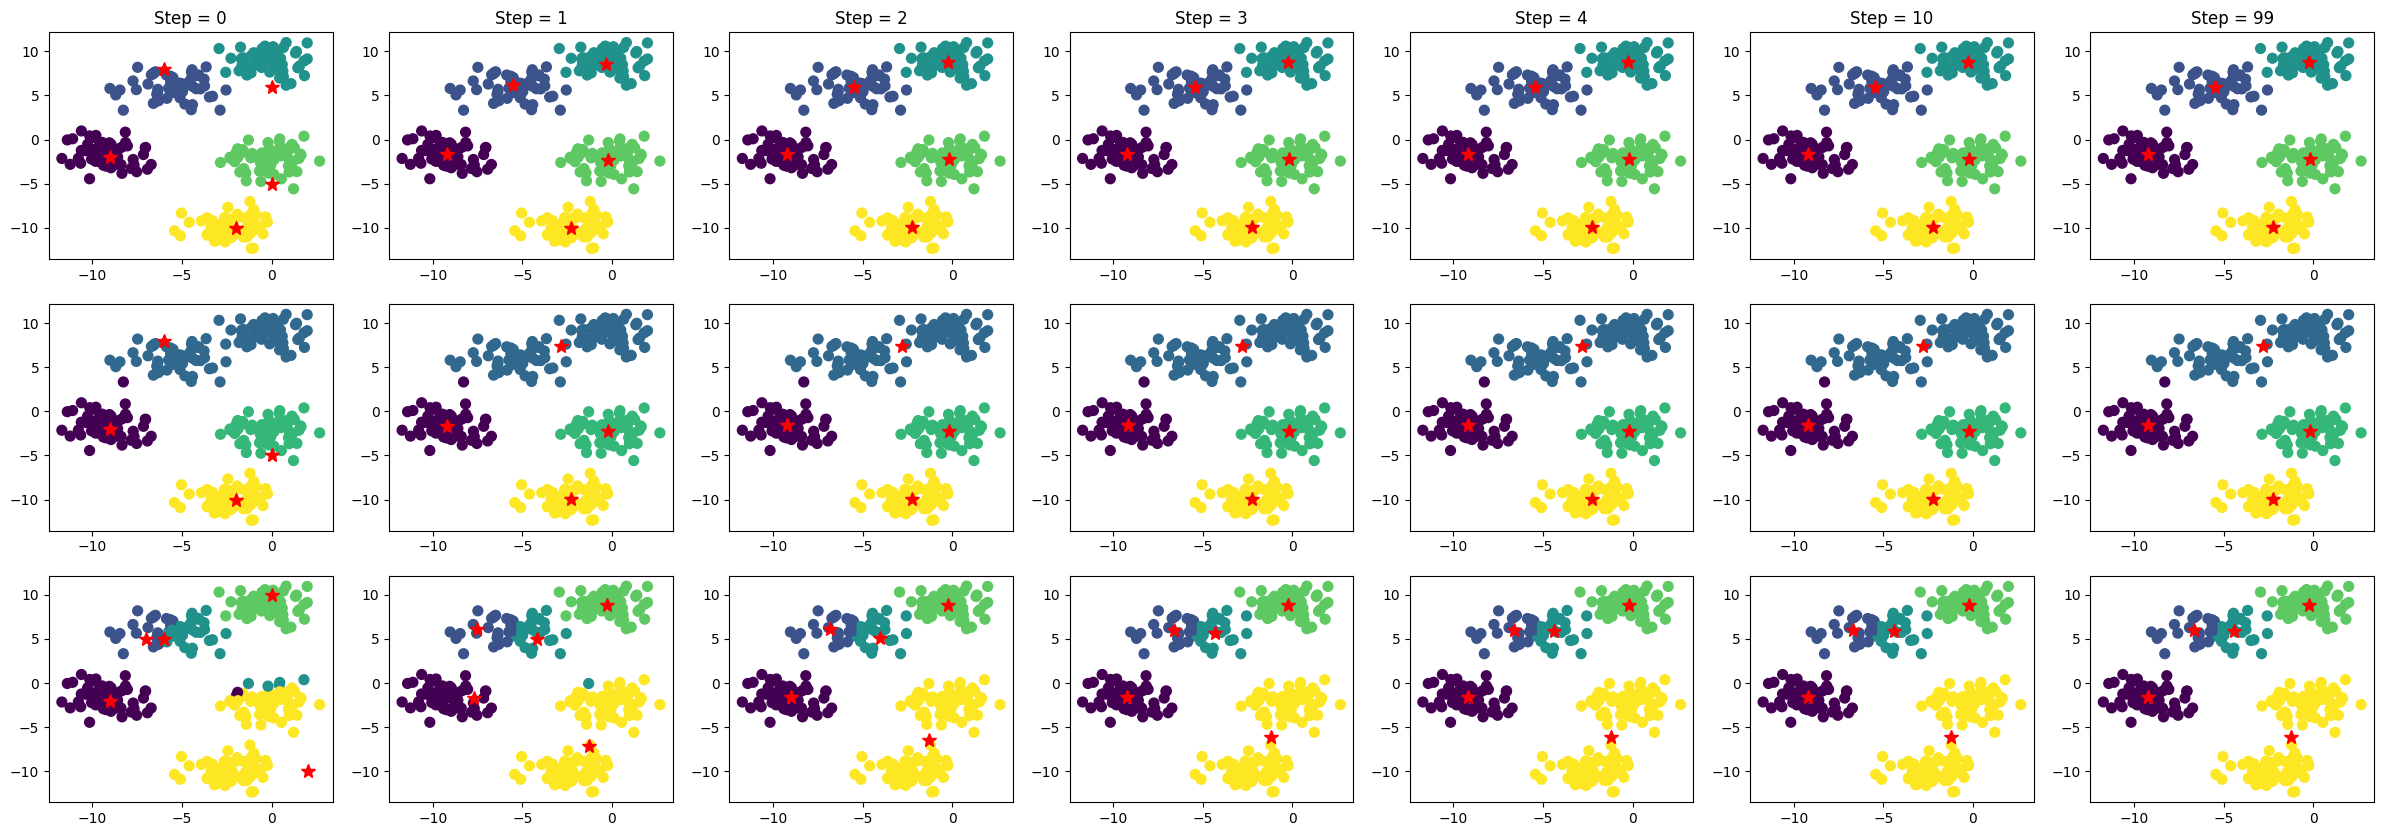

In [7]:
steps = [0, 1, 2, 3, 4, 10, 99]

fig, ax = plt.subplots(3, 7, figsize=(30, 10))

ind = 0
for i in steps:
    ax[0,ind].scatter(X[:, 0], X[:, 1], s=50, c = y_pred_1[i]);
    ax[0,ind].plot(centers_1[i].transpose()[0], centers_1[i].transpose()[1], marker='*', color = 'red', ls='none', ms=10)
    ax[0,ind].set_title('Step = ' + str(i))
    ind = ind+1
    
ind = 0
for i in steps:
    ax[1,ind].scatter(X[:, 0], X[:, 1], s=50, c = y_pred_2[i]);
    ax[1,ind].plot(centers_2[i].transpose()[0], centers_2[i].transpose()[1], marker='*', color = 'red', ls='none', ms=10)
    ind = ind+1
    
ind = 0
for i in steps:
    ax[2,ind].scatter(X[:, 0], X[:, 1], s=50, c = y_pred_3[i]);
    ax[2,ind].plot(centers_3[i].transpose()[0], centers_3[i].transpose()[1], marker='*', color = 'red', ls='none', ms=10)
    ind = ind+1
    
plt.show()

### Your Turn - Task 1
The above plots are three examples of the K-Means algorithm on the same synthetic data set with k=5 clusters. Each row corresponds to one example run of the K-Means algorithm. Each column shows the centroids (red stars) as well as the cluster assignments after an intermediate step of the algorithm. Specifically, we visualize the following time steps: 0, 1, 2, 3, 4, 10, and 99. Note that the maximum number of iterations was 100, so time step 99 corresponds to the final solution.
What do you observe? Does K-Means recover the original clusters? Discuss your observations and send them to us.

In [ ]:
import requests

exec(requests.get("https://courdier.pythonanywhere.com/get-send-code").content)

npt_config = {
    'session_name': 'lecture-10',
    'session_owner': 'mlbd',
    'sender_name': input("Your name: "),
}

In [ ]:
observation_example1 = ""
send(observation_example1, 1)

In [ ]:
observation_example2 = ""
send(observation_example2, 2)

In [ ]:
observation_example3 = ""
send(observation_example3, 3)

## Spectral Clustering

In contrast to K-Means, spectral clustering makes no assumption about the form/shape of the clusters. The different data points are treated as nodes of graphs and the clustering is done based on connectivity of the graph. In a first step, we use spectral clustering to cluster the two simulated data sets. We again assume that the correct number of clusters is known a-priori. We will use an unnormalized Laplacian for all our experiments.

We compute the pairwise similarity matrix using the radial basis function or Gaussian kernel, defined as:

$$s_{ij} = s\left(\boldsymbol{x_i}, \boldsymbol{x_j}\right) = \exp(-\gamma ||\boldsymbol{x_i} - \boldsymbol{x_j}||^2)$$

where $\gamma$ is a hyperparameter that must be tuned, controlling the width of the kernel.

Once we have the similarity matrix S, we need to compute the adjacency matrix W.

In [8]:
def get_adjacency(S, connectivity='full'):
    """
    Computes the adjacency matrix
    :param S: np array of similarity matrix
    :param connectivity: type of connectivity 
    :return: adjacency matrix
    """
    
    if(connectivity=='full'):
        adjacency = S
    elif(connectivity=='epsilon'):
        epsilon = 0.5
        adjacency = np.where(S > epsilon, 1, 0)
    else:
        raise RuntimeError('Method not supported')
        
    return adjacency

We then can implement the spectral clustering algorithm, giving the adjacency matrix W as an input.

In [9]:
def spectral_clustering(W, n_clusters, random_state=111):
    """
    Spectral clustering
    :param W: np array of adjacency matrix
    :param n_clusters: number of clusters
    :param normed: normalized or unnormalized Laplacian
    :return: tuple (kmeans, proj_X, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        proj_X is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues 
        
    """
    # Compute eigengap heuristic
    L = laplacian(W, normed=True)
    eigenvals, _ = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvals_sorted = eigenvals[np.argsort(eigenvals)]

    # Create embedding
    random_state = np.random.RandomState(random_state)
    proj_X = spectral_embedding(W, n_components=n_clusters,
                              random_state=random_state,
                              drop_first=False)

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state)
    kmeans.fit(proj_X)

    return kmeans, proj_X, eigenvals_sorted

For spectral clustering, we can for example use the eigengap heuristic or the Silhouette score to determine the optimal number of clusters. Next, we write functions to compute spectral clustering for a varying number of k and visualize these two heuristics.

In [10]:
def plot_metrics(n_clusters_list, metric_dictionary):
    """
    Plots metric dictionary (auxilary function)
    [Optional]
    
    :param n_clusters_list: List of number of clusters to explore 
    :param metric_dictionary: 
    """
    fig = plt.figure(figsize=(12, 10), dpi=80)
    i = 1

    for metric in metric_dictionary.keys():
        plt.subplot(3, 2, i)

        if metric == 'Eigengap':
            clusters = len(n_clusters_list)
            eigenvals_sorted = metric_dictionary[metric]
            plt.scatter(range(1, len(eigenvals_sorted[:clusters * 2]) + 1), eigenvals_sorted[:clusters * 2])
            plt.xlabel('Eigenvalues')
            plt.xticks(range(1, len(eigenvals_sorted[:clusters * 2]) + 1))
        else:
            plt.plot(n_clusters_list, metric_dictionary[metric], '-o')
            plt.xlabel('Number of clusters')
            plt.xticks(n_clusters_list)
        plt.ylabel(metric)
        i += 1


def get_heuristics_spectral(A, n_clusters_list, plot=True):
    """
    Calculates heuristics for optimal number of clusters with Spectral Clustering
    
    :param A: affinity matrix
    :param n_clusters_list: List of number of clusters to explore
    :plot: bool, plot the metrics if true
    """
    silhouette_list = []
    distortion_list = []
    bic_list = []
    eigengap_list = []
    davies_bouldin_list = []

    for k in n_clusters_list:

        kmeans, proj_X, eigenvals_sorted = spectral_clustering(A, k)
        y_pred = kmeans.labels_

        if k == 1:
            silhouette = np.nan
        else:
            silhouette = silhouette_score(proj_X, y_pred)
        silhouette_list.append(silhouette)


    metric_dictionary = {
                         'Silhouette': silhouette_list,
                         'Eigengap': eigenvals_sorted,
                        }
    
    if(plot):
        plot_metrics(n_clusters_list, metric_dictionary)
    else:
        return metric_dictionary

## Spectral Clustering on Flipped Classroom Data

Given the favorable properties of spectral clustering, we will use it to cluster the students of our flipped classroom data set. We first parse and preprocess the data.

In [11]:
df = pd.read_csv('{}/aggregated_extended_fc.csv'.format(DATA_DIR))
df = df.fillna('NaN')
df.head()

,user,ch_num_sessions,ch_time_in_prob_sum,ch_time_in_video_sum,ch_ratio_clicks_weekend_day,ch_total_clicks_weekend,ch_total_clicks_weekday,ch_time_sessions_mean,ch_time_sessions_std,bo_delay_lecture,...,la_weekly_prop_watched_mean,la_weekly_prop_interrupted_mean,la_weekly_prop_interrupted_std,la_weekly_prop_replayed_mean,la_weekly_prop_replayed_std,la_frequency_action_video_play,grade,gender,category,year
0,0,1.9,2334.4,2951.8,0.850000,16.8,38.1,1392.858333,790.762032,55068.387500,...,0.245714,0.024286,0.0,0.010000,0.0,0.179203,4.50,NaN,NaN,Y2-2018-19
1,1,3.4,1698.4,9227.8,0.567500,4.0,179.4,3068.720238,1257.504407,-2883.367738,...,0.748868,0.074683,0.0,0.066456,0.0,0.332424,4.50,M,Suisse.Autres,Y2-2018-19
2,2,5.3,2340.6,10801.3,26.562274,94.6,129.2,1750.289268,1024.134043,10027.216667,...,0.354487,0.026667,0.0,0.059915,0.0,0.284407,5.25,M,Suisse.PAM,Y2-2018-19
3,3,2.8,2737.1,8185.5,3.691250,13.5,46.4,20203.590260,656.052901,27596.864484,...,0.370000,0.014286,0.0,0.020000,0.0,0.108774,4.50,F,Suisse.Autres,Y2-2018-19
4,4,2.5,3787.3,7040.0,1.543889,58.4,64.9,3373.908333,1363.320365,-914.633333,...,0.030000,0.000000,0.0,0.020000,0.0,0.199775,4.75,F,France,Y2-2018-19


Specifically, we are interested in clustering the students based on their behavior in the course. We investigate two different type of behaviors. The first behavior is related to students effort. We use the following three features as indicators: `ch_time_in_prob_sum`, `ch_time_in_video_sum`, `ch_total_clicks_weekend`, `ch_total_clicks_weekday`. We sum up the time in problems and videos to obtain the total time spent on the platform. Similarly, we also sum up the number of clicks in problems and videos to obtain the total number of clicks.

The second behavior is related to students proactivity in the course. Use the following two features as indicators of how proactive the students are: `ma_content_anti`, `bo_delay_lecture` and follow the previous steps.

In [12]:
df['ch_time_sum'] = df.ch_time_in_prob_sum + df.ch_time_in_video_sum
df['ch_total_clicks'] = df.ch_total_clicks_weekend + df.ch_total_clicks_weekday

### Your Turn - Task 2
Pick one of the two behaviors (effort or proactivity) and use spectral clustering to cluster students according to this behavior.

In a first step you will need to normalize or standardize the features.

In [13]:
# Data standardization/normalization


Next, compute the pairwise similarity matrices separately for each feature using a Gaussian kernel. We can then simply sum up the similarity matrices up to obtain the overall similarity matrix S.

In [14]:
# Pariwise kernels
# Hint: use scikit-learn pairwise_kernels


Next, we compute the adjacency matrix W.

In [15]:
# Compute adjacency matrix
# Hint: get_adjacency function above

Finally, we perform a spectral clustering for k=2,...,10 and compute the Silhouette score as well as the eigengap heuristic.

In [16]:
# Compute spectral clustering, heuristics, and visualization
# Hint: get_heuristics_spectral function above

In [ ]:
# What do you observe? What is the optimal number of clusters? Do both metrics agree? 
observation = ""
send(observation, 4)

### Your Turn - Task 3
If you have time, replicate the analyses for the second feature group.

In [ ]:
# Replicate analysis for second feature group

In [ ]:
# What do you observe? What is the optimal number of clusters? Do both metrics agree? 
observation = ""
send(observation, 5)